In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
import numpy as np
import os
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
from Constants.constants import TOPICS, TOPICS_MAP, DOCUMENTS_PATH

In [2]:
def create_dataset(topics):
    data = {'hash':[],'topic': [], 'text': []}
    for topic in topics:
        for file in os.listdir(os.path.join(DOCUMENTS_PATH,topic)):
            with open(os.path.join(DOCUMENTS_PATH, topic, file), "r", encoding="utf-8") as f:
                text = f.read()
                data['hash'].append(file)
                data['topic'].append(topic)
                data['text'].append(text)
    return pd.DataFrame(data)

data = create_dataset(TOPICS)
data

,hash,topic,text
0,0447d5ebcb5fb4c3c35428319d035a2b43f53c8561d683...,Astronomy,unidentified rocket displayed military parade ...
1,070c9fd24e43ba164f3a68dd8c976a57461fceb038a43d...,Astronomy,cosmic countdown begun director james gunn ’ `...
2,09559783f5ee1852885289ba8fd16625284625dd41875e...,Astronomy,planetary society taking stand nasa 's stalled...
3,09d01585d21facc6f893ec9c64a6d79ffc107be243f10d...,Astronomy,may helpful receive news updates notifications...
4,0a3d8dfb0821ff1ed7ad6fd00ad318c667f9300b37ea71...,Astronomy,spacex falcon 9 rocket used first stage launch...
...,...,...,...
414,ee08e9f7217762e3b506a0ac9489ccdd560bd9ae174f04...,Economy,atsushi ikeda founder japanese club tesla owne...
415,eea2c24632f92505ff2ca5943b32cbbecc275108b6d161...,Economy,10-yr bondnasdaqvolatilityftsenikkei 225cad/eu...
416,f0b07ab98c445e62cfbed189b95c7414c45c1c28256329...,Economy,spike oil prices surprise opec+ production cut...
417,f5588a9b6dd95855a3150f9779f7c229c02a42ce688995...,Economy,u.s. stocks open lower investors receive anoth...


In [3]:
def preprocess(data,topics_map):
    tokenizer = RegexpTokenizer(r'\w+')
    data['text'] = data['text'].apply(lambda x: tokenizer.tokenize(x.lower()))
    data['text'] = data['text'].apply(lambda x: ' '.join(x))
    data['label'] = data['topic'].map(topics_map)
    X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=0)
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = preprocess(data,TOPICS_MAP)
X_train

7      next week europe fly first mission jupiter sys...
134    artemis 2 big news canadian space agency csa c...
22     purchase links site may earn affiliate commiss...
68     tag archives budget 2019canadian space agency ...
306    prices slid backdrop gloomy us economic sentim...
                             ...                        
323    cad eurbank canada rate hikes hitting immigran...
192    recognize anxiety symptoms teensschool exams t...
117    mit astronomers mapped disk winds associated a...
47     tag archives radarsat 2mda ceo mike greeney po...
172    probiotics help manage symptoms menopause prob...
Name: text, Length: 335, dtype: object

In [4]:
def create_tf_idf(X_train,X_test):
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    return X_train_tfidf, X_test_tfidf
X_train_tfidf, X_test_tfidf = create_tf_idf(X_train,X_test)
X_train_tfidf

<335x20699 sparse matrix of type '<class 'numpy.float64'>'
	with 105848 stored elements in Compressed Sparse Row format>

In [9]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

def cross_validate_and_train(model,X_train_tfidf,y_train):
    scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score,average='macro'),
           'recall': make_scorer(recall_score, average='macro'),
           'f1_score': make_scorer(f1_score, average='macro')}
    K_folds = 5
    cv_results = cross_validate(model, X_train_tfidf, y_train, cv=K_folds, scoring=scoring, return_estimator=True)
    for i in range(K_folds):
        print(f"Fold: {i+1}")
        print(f"Accuracy: {cv_results['test_accuracy'][i]}")
        print(f"Precision: {cv_results['test_precision'][i]}")
        print(f"Recall: {cv_results['test_recall'][i]}")
        print(f"F1 Score: {cv_results['test_f1_score'][i]}")
        print("\n")
    print("Mean Metrics")
    print(f"Mean Accuracy: {np.mean(cv_results['test_accuracy'])}")
    print(f"Mean Precision: {np.mean(cv_results['test_precision'])}")
    print(f"Mean Recall: {np.mean(cv_results['test_recall'])}")
    print(f"Mean F1 Score: {np.mean(cv_results['test_f1_score'])}")

    mean_scores = {metric: np.mean(cv_results[f'test_{metric}']) for metric in scoring.keys()}
    best_metric = max(mean_scores, key=mean_scores.get)
    best_estimator_index= np.argmax(cv_results['test_'+best_metric])
    best_estimator = cv_results['estimator'][best_estimator_index]
    print(f"Best Estimator: {best_estimator_index}")
    return best_estimator

In [6]:
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay, RocCurveDisplay
def test_model(model,X_test_tfidf,y_test, plot=False):
    print("Test Metrics")
    y_pred = model.predict(X_test_tfidf)
    #Test to see if predict_proba works
    _ = model.predict_proba(X_test_tfidf)
    print(classification_report(y_test, y_pred))
    report = classification_report(y_test, y_pred, output_dict=True)
    if plot:
        cm = confusion_matrix(y_test, y_pred)
        ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot()
        plt.show()
    return report

Model: SVC
Fold: 1
Accuracy: 0.9850746268656716
Precision: 0.9861111111111112
Recall: 0.9848484848484849
F1 Score: 0.9851558634339436


Fold: 2
Accuracy: 0.9701492537313433
Precision: 0.9733333333333333
Recall: 0.9696969696969697
F1 Score: 0.9706072351421189


Fold: 3
Accuracy: 0.9701492537313433
Precision: 0.9722222222222222
Recall: 0.9696969696969697
F1 Score: 0.9696342305037957


Fold: 4
Accuracy: 0.9552238805970149
Precision: 0.96
Recall: 0.955862977602108
F1 Score: 0.9558199511193078


Fold: 5
Accuracy: 0.9850746268656716
Precision: 0.9855072463768115
Recall: 0.9848484848484849
F1 Score: 0.9848406546080964


Mean Metrics
Mean Accuracy: 0.973134328358209
Mean Precision: 0.9754347826086956
Mean Recall: 0.9729907773386035
Mean F1 Score: 0.9732115869614525
Best Estimator: 0
[0 1 2]
Test Metrics
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        31
           1       1.00      1.00      1.00        24
           2       1.00      0

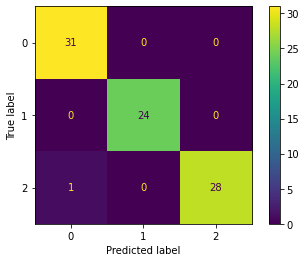



Model: KNeighborsClassifier
Fold: 1
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Fold: 2
Accuracy: 0.9701492537313433
Precision: 0.9716183574879228
Recall: 0.9696969696969697
F1 Score: 0.9696273781380165


Fold: 3
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Fold: 4
Accuracy: 0.9850746268656716
Precision: 0.9855072463768115
Recall: 0.9855072463768115
F1 Score: 0.9851851851851853


Fold: 5
Accuracy: 0.9850746268656716
Precision: 0.9855072463768115
Recall: 0.9855072463768115
F1 Score: 0.9851851851851853


Mean Metrics
Mean Accuracy: 0.9880597014925373
Mean Precision: 0.9885265700483092
Mean Recall: 0.9881422924901185
Mean F1 Score: 0.9879995497016774
Best Estimator: 0
[0 1 2]
Test Metrics
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        31
           1       1.00      1.00      1.00        24
           2       1.00      0.97      0.98        29

    accuracy                           0.99        84
   mac

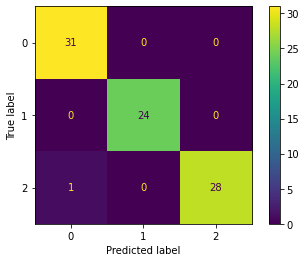



Model: DecisionTreeClassifier
Fold: 1
Accuracy: 0.9402985074626866
Precision: 0.9456654456654455
Recall: 0.9393939393939394
F1 Score: 0.9404630069081895


Fold: 2
Accuracy: 0.8805970149253731
Precision: 0.8845454545454546
Recall: 0.8801054018445322
F1 Score: 0.8811327561327561


Fold: 3
Accuracy: 0.9253731343283582
Precision: 0.9307936507936508
Recall: 0.9255599472990778
F1 Score: 0.9261316779871951


Fold: 4
Accuracy: 0.8955223880597015
Precision: 0.9046015712682379
Recall: 0.8978919631093545
F1 Score: 0.8939243103006169


Fold: 5
Accuracy: 0.8955223880597015
Precision: 0.898977879481312
Recall: 0.8959156785243741
F1 Score: 0.8945947368816888


Mean Metrics
Mean Accuracy: 0.9074626865671641
Mean Precision: 0.9129168003508201
Mean Recall: 0.9077733860342556
Mean F1 Score: 0.9072492976420893
Best Estimator: 0
[0 1 2]
Test Metrics
              precision    recall  f1-score   support

           0       0.88      0.97      0.92        31
           1       0.95      0.88      0.91     

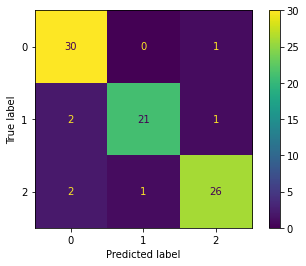



Model: LogisticRegression
Fold: 1
Accuracy: 0.9850746268656716
Precision: 0.9861111111111112
Recall: 0.9848484848484849
F1 Score: 0.9851558634339436


Fold: 2
Accuracy: 0.9701492537313433
Precision: 0.9733333333333333
Recall: 0.9696969696969697
F1 Score: 0.9706072351421189


Fold: 3
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Fold: 4
Accuracy: 0.9701492537313433
Precision: 0.9722222222222222
Recall: 0.9703557312252965
F1 Score: 0.970347900984908


Fold: 5
Accuracy: 0.9701492537313433
Precision: 0.9722222222222222
Recall: 0.9703557312252965
F1 Score: 0.970347900984908


Mean Metrics
Mean Accuracy: 0.9791044776119403
Mean Precision: 0.9807777777777777
Mean Recall: 0.9790513833992096
Mean F1 Score: 0.9792917801091757
Best Estimator: 2
[0 1 2]
Test Metrics
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00        24
           2       1.00      1.00      1.00        29

    

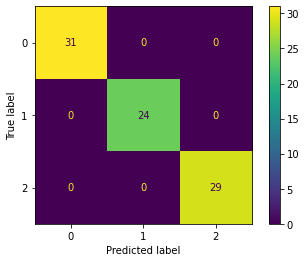



Model: GaussianNB
Fold: 1
Accuracy: 0.9701492537313433
Precision: 0.9696969696969697
Recall: 0.9696969696969697
F1 Score: 0.9696969696969697


Fold: 2
Accuracy: 0.9253731343283582
Precision: 0.9404761904761904
Recall: 0.9242424242424243
F1 Score: 0.9270570016624534


Fold: 3
Accuracy: 0.9552238805970149
Precision: 0.9550865800865802
Recall: 0.9545454545454546
F1 Score: 0.9545004723134362


Fold: 4
Accuracy: 0.9253731343283582
Precision: 0.9273088023088022
Recall: 0.9262187088274044
F1 Score: 0.9255599472990776


Fold: 5
Accuracy: 0.9850746268656716
Precision: 0.9855072463768115
Recall: 0.9848484848484849
F1 Score: 0.9848406546080964


Mean Metrics
Mean Accuracy: 0.9522388059701493
Mean Precision: 0.9556151577890708
Mean Recall: 0.9519104084321477
Mean F1 Score: 0.9523310091160067
Best Estimator: 4
[0 1 2]
Test Metrics
              precision    recall  f1-score   support

           0       0.97      0.90      0.93        31
           1       0.88      0.96      0.92        24
     

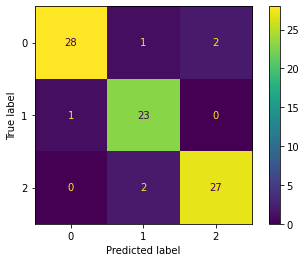

In [7]:
def train_and_test_models(X_train_tfidf,y_train,X_test_tfidf,y_test):
    models = [SVC(probability=True),KNeighborsClassifier(),DecisionTreeClassifier(),LogisticRegression(),GaussianNB()]
    reports = {}
    for model in models:
        print(f"Model: {model.__class__.__name__}")
        if model.__class__.__name__ == "GaussianNB":
            X_train_tfidf = X_train_tfidf.toarray()
            X_test_tfidf = X_test_tfidf.toarray()
        best_estimator = cross_validate_and_train(model,X_train_tfidf,y_train)
        print(best_estimator.classes_)
        report = test_model(best_estimator,X_test_tfidf,y_test,plot=True)
        reports[model.__class__.__name__] = [best_estimator,report]
        print("\n")
    return reports
reports = train_and_test_models(X_train_tfidf,y_train,X_test_tfidf,y_test)

In [8]:
def choose_best_model(reports):
    #Choose best model based on highest accuracy, precision, recall and f1 score
    best_model = None
    best_score = 0
    model_name = None
    for model in reports:
        report = reports[model][1]
        score = report['accuracy'] + report['macro avg']['precision'] + report['macro avg']['recall'] + report['macro avg']['f1-score']
        if score > best_score:
            best_score = score
            best_model = reports[model][0]
            model_name = model
    return model_name, best_model
model_name, best_model = choose_best_model(reports)
print(f"Best Model: {model_name}")

Best Model: LogisticRegression


In [10]:
def knn_grid_search(X_train_tfidf, y_train):
    param_grid = {'n_neighbors': [3, 5, 7, 9]}
    knn = KNeighborsClassifier()
    grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train_tfidf, y_train)
    print(grid_search.best_params_)
    print(grid_search.best_score_)
    return grid_search.best_estimator_
knn_best_estimator = knn_grid_search(X_train_tfidf, y_train)

{'n_neighbors': 3}
0.991044776119403


In [11]:
probs = best_model.predict_proba(X_test_tfidf)
for prob in probs:
    print(prob)

[0.04798808 0.91005561 0.04195631]
[0.24006877 0.55939334 0.20053789]
[0.7495009  0.11366231 0.13683678]
[0.14280206 0.73042174 0.1267762 ]
[0.02942567 0.94550621 0.02506811]
[0.02942567 0.94550621 0.02506811]
[0.71704113 0.13674621 0.14621266]
[0.06838437 0.86614632 0.0654693 ]
[0.16210249 0.70071598 0.13718153]
[0.17757818 0.16680589 0.65561593]
[0.87481343 0.06255197 0.0626346 ]
[0.33262643 0.30663383 0.36073974]
[0.14420459 0.14903247 0.70676294]
[0.77809526 0.12200892 0.09989583]
[0.81048935 0.08433011 0.10518054]
[0.04406187 0.91683294 0.03910519]
[0.90136822 0.04753581 0.05109597]
[0.21514798 0.59569547 0.18915656]
[0.73452416 0.12884696 0.13662888]
[0.1255887  0.13206174 0.74234956]
[0.74061404 0.14289495 0.11649101]
[0.58959277 0.20779203 0.2026152 ]
[0.07117923 0.07228896 0.85653181]
[0.13108437 0.09670565 0.77220998]
[0.63555775 0.21119817 0.15324408]
[0.1471233  0.12464765 0.72822905]
[0.47836112 0.25119758 0.2704413 ]
[0.02963056 0.03020991 0.94015953]
[0.03696794 0.933420

In [13]:
# def save_model(model):
#     joblib.dump(model, "classifier.joblib")